In [2]:
def unpaint_dataset():
    pass

import torchvision
from torchvision import transforms
import torch
import matplotlib.pyplot as plt

def unpaint_center(images, mask_size=0.5):
    img_size = images.shape[-1]
    mask = torch.ones_like(images)
    mask[:, int(mask_size / 2 * img_size):img_size - int(mask_size / 2 * img_size), int(mask_size / 2 * img_size):img_size - int(mask_size / 2 * img_size)] = 0
    return torch.mul(images, mask)

def gaussian_blurring(images):
    import cv2
    Gaussian = cv2.GaussianBlur(images, (7, 7), 0)
    

batch_size = 64

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

unpaint_center_transform =  transforms.Compose(
    [transforms.ToTensor(),
     unpaint_center,
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset_cifar = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset_cifar, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

unpainted_trainset_cifar = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=unpaint_center_transform)

testset_cifar = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset_cifar, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


sample_images = next(iter(trainloader))[0]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


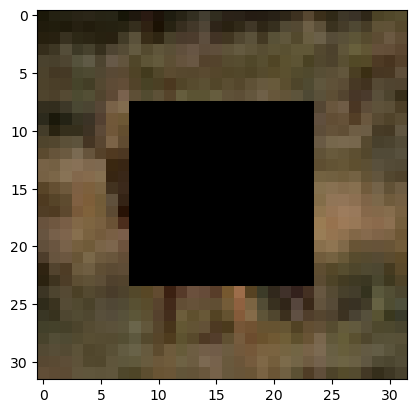

In [32]:
plt.imshow((unpainted_trainset_cifar[3][0].permute([1, 2, 0]) * 0.5 + 0.5))


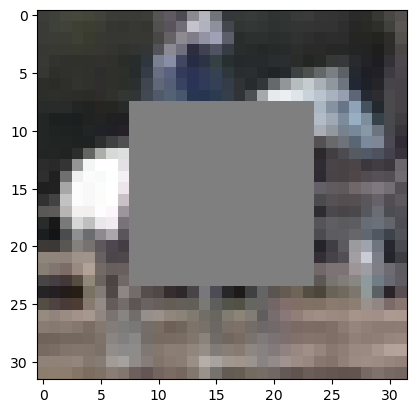

In [24]:
plt.imshow((unpaint_center(sample_images)[3].permute([1, 2, 0]) * 0.5 + 0.5))


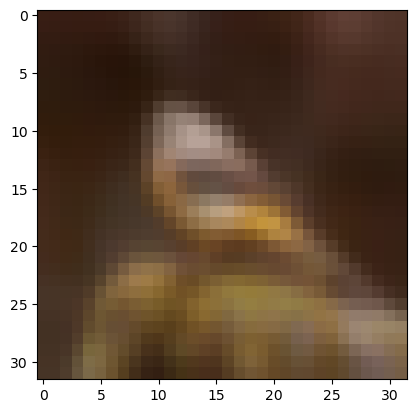

In [15]:

def gaussian_blurring(images):
    blurring_fn = torchvision.transforms.GaussianBlur(5, sigma=(0.1, 1.0))
    return blurring_fn(images)
    
gaussian_blurring(sample_images)
plt.imshow(gaussian_blurring(sample_images)[0].permute([1, 2, 0]) * 0.5 + 0.5)

In [28]:
celeba_transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Resize((128, 128)),
                torchvision.transforms.Normalize([0.5],[0.5])
            ])
celeba_train = torchvision.datasets.CelebA('data', 'train', transform=celeba_transform, download=True)


Files already downloaded and verified


In [35]:
fig = plt.figure()
ax = fig1.add_subplot(1,1,1) 
ax.imshow(torch.tensor(celeba_train[0][0]).permute([1, 2, 0]) * 0.5 + 0.5)
plt.show()

/tmp/ipykernel_552640/926456421.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ax.imshow(torch.tensor(celeba_train[0][0]).permute([1, 2, 0]) * 0.5 + 0.5)


<Figure size 640x480 with 0 Axes>

/tmp/ipykernel_552640/4004375251.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.tensor(celeba_train[0][0]).permute([1, 2, 0]) * 0.5 + 0.5)


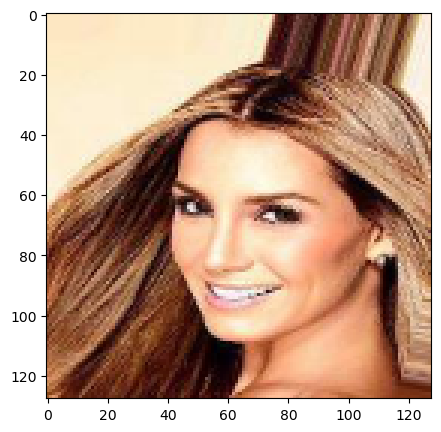

In [43]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.imshow(torch.tensor(celeba_train[0][0]).permute([1, 2, 0]) * 0.5 + 0.5)
# plt.show()

In [5]:
import torch
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=64)
# imgs_dist1 = torch.randint(0, 200, (100, 3, 299, 299), dtype=torch.uint8)
imgs_dist1 = torch.tensor((sample_images * 0.5 + 0.5) * 255, dtype=torch.uint8)
imgs_dist2 = torch.zeros_like(sample_images, dtype=torch.uint8)
fid.update(imgs_dist1, real=True)
fid.update(imgs_dist2, real=False)
fid.compute()

/tmp/ipykernel_886772/3718497535.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgs_dist1 = torch.tensor((sample_images * 0.5 + 0.5) * 255, dtype=torch.uint8)


tensor(32.2959)

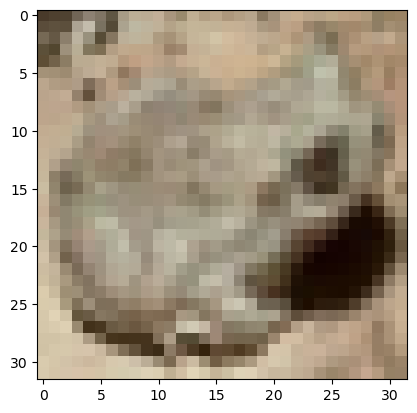

In [8]:
plt.imshow(imgs_dist1[0].permute([1, 2, 0]))

In [95]:
%reload_ext autoreload
%autoreload 2

/tmp/ipykernel_886772/3332526372.py:79: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  t_range = torch.range(0, 1, step=0.01)


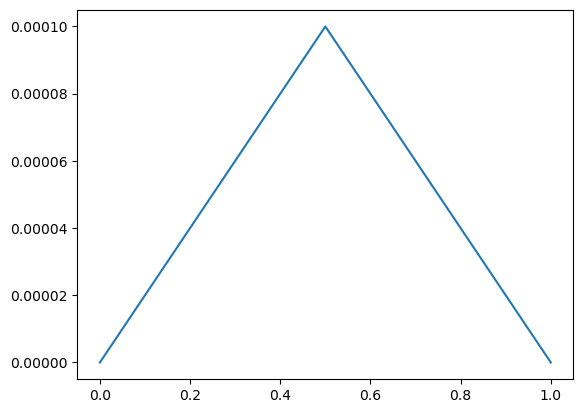

In [148]:
from bridge_matching import BridgeMathcing, LinearBridgeNoiseScheduler, BridgeNoiseScheduler
from copy import deepcopy
import torch.nn as nn
from tqdm import tqdm as tqdm

class BridgeMathcing(nn.Module):
    def __init__(self, unet, scheduler: BridgeNoiseScheduler):
        super().__init__()
        self.vector_net = unet
        self.euler_dt = 0.01
        self.sch = scheduler
        
    def forward(self, x_0):
        # solve forward ODE via Euler or torchdiffeq solver
        x_t = x_0
        
        t_range = tqdm(torch.arange(0, 1, step=self.euler_dt))
        
        for t in t_range:
            eps_noise = torch.randn_like(x_t)
            beta_t = self.sch.beta(t)
            x_t = x_t + self.vector_net(x_t, t) * self.euler_dt + torch.sqrt(self.euler_dt * beta_t) * eps_noise
            
        return x_t

    @torch.no_grad()
    def sample(self, x_0, pbar=True):
        x_t = x_0
        
        if pbar:
            t_range = tqdm(torch.arange(0, 1, step=self.euler_dt))
        else:
            t_range = torch.arange(0, 1, step=self.euler_dt)
        
        x_t_storage = []
        
        for t in t_range:
            eps_noise = torch.randn_like(x_t)
            beta_t = self.sch.beta(t)
            print(self.vector_net(x_t, t).mean())
            x_t = x_t + self.vector_net(x_t, t) * self.euler_dt # + torch.sqrt(self.euler_dt * beta_t) * eps_noise
            x_t_storage.append(deepcopy(x_t))
        
        return x_t_storage

    def sample_x_t(self, x_0, x_1, t):
        sigma_t_sq = self.sch.sigma(t) ** 2
        sigma_overlined_t_sq = self.sch.sigma_overlined(t) ** 2

        coef_0, coef_1 = sigma_overlined_t_sq / (sigma_t_sq + sigma_overlined_t_sq), sigma_t_sq / (sigma_t_sq + sigma_overlined_t_sq)

        std_t = torch.sqrt(sigma_t_sq * sigma_overlined_t_sq / (sigma_overlined_t_sq + sigma_t_sq))

        x_t = coef_1.reshape([-1, 1, 1, 1]) * x_1 + coef_0.reshape([-1, 1, 1, 1]) * x_0 + torch.randn_like(x_0) * std_t.reshape([-1, 1, 1, 1])
        return x_t
    
    def step(self, x_0, x_1, t):
        t = t.reshape([-1, 1, 1, 1])
        x_t = self.sample_x_t(x_0, x_1, t)
        x_t_hat = self.vector_net(x_t, t)
        print()
        return self.loss(x_t_hat, x_1, x_t, t).mean()
    
    def loss(self, x_t_hat, x_1, x_t, t):
        beta_t = self.sch.beta(t)
        sigma_overlined_t = self.sch.sigma_overlined(t)
        return torch.norm((x_t_hat - beta_t * (x_1 - x_t) / (sigma_overlined_t ** 2)).reshape([x_1.shape[0], -1]), dim=-1)

from unet import UNet

sch = LinearBridgeNoiseScheduler(1e-4)

bm_model = BridgeMathcing(UNet(3, base_channels=128, channel_mults=(1, 2, 4)), sch)
bm_model.load_state_dict(torch.load('bm_debur_mnist_test.pth'))

device = 'cuda:1'
bm_model.to(device)

t_range = torch.range(0, 1, step=0.01)

beta = sch.beta(t_range)
plt.plot(t_range, beta)

In [149]:

def unpaint_center(images, mask_size=0.5):
    img_size = images.shape[-1]
    mask = torch.ones_like(images)
    mask[:, int(mask_size / 2 * img_size):img_size - int(mask_size / 2 * img_size), int(mask_size / 2 * img_size):img_size - int(mask_size / 2 * img_size)] = 0
    return torch.mul(images, mask)

mnist_transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
                torchvision.transforms.Normalize([0.5],[0.5])
            ])
mnist_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=mnist_transform, download=True)

from utils import gaussian_blurring

x_1 = mnist_dataset[0][0]
x_0 = gaussian_blurring(x_0)
x_t_samples = bm_model.sample_x_t(x_0.unsqueeze(0).repeat([t_range.shape[0], 1, 1, 1]), x_1.unsqueeze(0).repeat([t_range.shape[0], 1, 1, 1]), t_range)



In [150]:

loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size,
                                      shuffle=True, num_workers=0, drop_last=True)
    
x_0_samples = gaussian_blurring(next(iter(loader))[0].to(device))

In [151]:
x_t = bm_model.sample(x_0_samples)

  1%|█▋                                                                                                                                                                         | 1/100 [00:00<00:11,  8.48it/s]

tensor(0.0035, device='cuda:1')


  2%|███▍                                                                                                                                                                       | 2/100 [00:00<00:18,  5.18it/s]

tensor(0.0034, device='cuda:1')


  3%|█████▏                                                                                                                                                                     | 3/100 [00:00<00:20,  4.66it/s]

tensor(0.0034, device='cuda:1')


  4%|██████▊                                                                                                                                                                    | 4/100 [00:00<00:20,  4.68it/s]

tensor(0.0034, device='cuda:1')


  5%|████████▌                                                                                                                                                                  | 5/100 [00:01<00:21,  4.44it/s]

tensor(0.0034, device='cuda:1')


  6%|██████████▎                                                                                                                                                                | 6/100 [00:01<00:21,  4.31it/s]

tensor(0.0034, device='cuda:1')


  7%|███████████▉                                                                                                                                                               | 7/100 [00:01<00:20,  4.44it/s]

tensor(0.0034, device='cuda:1')


  8%|█████████████▋                                                                                                                                                             | 8/100 [00:01<00:21,  4.31it/s]

tensor(0.0035, device='cuda:1')


  9%|███████████████▍                                                                                                                                                           | 9/100 [00:02<00:21,  4.25it/s]

tensor(0.0035, device='cuda:1')


 10%|█████████████████                                                                                                                                                         | 10/100 [00:02<00:20,  4.40it/s]

tensor(0.0035, device='cuda:1')


 11%|██████████████████▋                                                                                                                                                       | 11/100 [00:02<00:20,  4.30it/s]

tensor(0.0035, device='cuda:1')


 12%|████████████████████▍                                                                                                                                                     | 12/100 [00:02<00:20,  4.23it/s]

tensor(0.0034, device='cuda:1')


 13%|██████████████████████                                                                                                                                                    | 13/100 [00:02<00:19,  4.40it/s]

tensor(0.0035, device='cuda:1')


 14%|███████████████████████▊                                                                                                                                                  | 14/100 [00:03<00:19,  4.30it/s]

tensor(0.0035, device='cuda:1')


 15%|█████████████████████████▌                                                                                                                                                | 15/100 [00:03<00:20,  4.23it/s]

tensor(0.0035, device='cuda:1')


 16%|███████████████████████████▏                                                                                                                                              | 16/100 [00:03<00:19,  4.38it/s]

tensor(0.0034, device='cuda:1')


 17%|████████████████████████████▉                                                                                                                                             | 17/100 [00:03<00:19,  4.28it/s]

tensor(0.0034, device='cuda:1')


 18%|██████████████████████████████▌                                                                                                                                           | 18/100 [00:04<00:19,  4.22it/s]

tensor(0.0034, device='cuda:1')


 19%|████████████████████████████████▎                                                                                                                                         | 19/100 [00:04<00:18,  4.40it/s]

tensor(0.0034, device='cuda:1')


 20%|██████████████████████████████████                                                                                                                                        | 20/100 [00:04<00:18,  4.30it/s]

tensor(0.0036, device='cuda:1')


 21%|███████████████████████████████████▋                                                                                                                                      | 21/100 [00:04<00:18,  4.25it/s]

tensor(0.0035, device='cuda:1')


 22%|█████████████████████████████████████▍                                                                                                                                    | 22/100 [00:04<00:17,  4.41it/s]

tensor(0.0034, device='cuda:1')


 23%|███████████████████████████████████████                                                                                                                                   | 23/100 [00:05<00:17,  4.30it/s]

tensor(0.0035, device='cuda:1')


 24%|████████████████████████████████████████▊                                                                                                                                 | 24/100 [00:05<00:17,  4.26it/s]

tensor(0.0034, device='cuda:1')


 25%|██████████████████████████████████████████▌                                                                                                                               | 25/100 [00:05<00:17,  4.37it/s]

tensor(0.0035, device='cuda:1')


 26%|████████████████████████████████████████████▏                                                                                                                             | 26/100 [00:05<00:17,  4.28it/s]

tensor(0.0035, device='cuda:1')


 27%|█████████████████████████████████████████████▉                                                                                                                            | 27/100 [00:06<00:17,  4.29it/s]

tensor(0.0036, device='cuda:1')


 28%|███████████████████████████████████████████████▌                                                                                                                          | 28/100 [00:06<00:16,  4.40it/s]

tensor(0.0034, device='cuda:1')


 29%|█████████████████████████████████████████████████▎                                                                                                                        | 29/100 [00:06<00:16,  4.30it/s]

tensor(0.0035, device='cuda:1')


 30%|███████████████████████████████████████████████████                                                                                                                       | 30/100 [00:06<00:16,  4.28it/s]

tensor(0.0034, device='cuda:1')


 31%|████████████████████████████████████████████████████▋                                                                                                                     | 31/100 [00:07<00:15,  4.38it/s]

tensor(0.0034, device='cuda:1')


 32%|██████████████████████████████████████████████████████▍                                                                                                                   | 32/100 [00:07<00:15,  4.31it/s]

tensor(0.0035, device='cuda:1')


 34%|█████████████████████████████████████████████████████████▊                                                                                                                | 34/100 [00:07<00:14,  4.46it/s]

tensor(0.0036, device='cuda:1')
tensor(0.0035, device='cuda:1')


 35%|███████████████████████████████████████████████████████████▍                                                                                                              | 35/100 [00:08<00:14,  4.34it/s]

tensor(0.0035, device='cuda:1')


 36%|█████████████████████████████████████████████████████████████▏                                                                                                            | 36/100 [00:08<00:14,  4.27it/s]

tensor(0.0035, device='cuda:1')


 37%|██████████████████████████████████████████████████████████████▉                                                                                                           | 37/100 [00:08<00:14,  4.42it/s]

tensor(0.0035, device='cuda:1')


 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 38/100 [00:08<00:14,  4.31it/s]

tensor(0.0035, device='cuda:1')


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                       | 39/100 [00:08<00:14,  4.26it/s]

tensor(0.0035, device='cuda:1')


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 40/100 [00:09<00:13,  4.38it/s]

tensor(0.0035, device='cuda:1')


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                    | 41/100 [00:09<00:13,  4.28it/s]

tensor(0.0035, device='cuda:1')


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                  | 42/100 [00:09<00:13,  4.26it/s]

tensor(0.0035, device='cuda:1')


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                 | 43/100 [00:09<00:13,  4.36it/s]

tensor(0.0035, device='cuda:1')


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                               | 44/100 [00:10<00:13,  4.30it/s]

tensor(0.0034, device='cuda:1')


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                             | 45/100 [00:10<00:12,  4.28it/s]

tensor(0.0034, device='cuda:1')


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                           | 46/100 [00:10<00:12,  4.45it/s]

tensor(0.0036, device='cuda:1')


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                          | 47/100 [00:10<00:12,  4.32it/s]

tensor(0.0035, device='cuda:1')


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 48/100 [00:11<00:12,  4.27it/s]

tensor(0.0035, device='cuda:1')
tensor(0.0035, device='cuda:1')


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 50/100 [00:11<00:11,  4.36it/s]

tensor(0.0033, device='cuda:1')


 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 51/100 [00:11<00:11,  4.31it/s]

tensor(0.0035, device='cuda:1')
tensor(0.0034, device='cuda:1')


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                | 53/100 [00:12<00:10,  4.35it/s]

tensor(0.0034, device='cuda:1')


 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 54/100 [00:12<00:10,  4.31it/s]

tensor(0.0035, device='cuda:1')


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 55/100 [00:12<00:10,  4.43it/s]

tensor(0.0034, device='cuda:1')


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 56/100 [00:12<00:10,  4.35it/s]

tensor(0.0034, device='cuda:1')


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 57/100 [00:13<00:10,  4.27it/s]

tensor(0.0034, device='cuda:1')


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 58/100 [00:13<00:09,  4.41it/s]

tensor(0.0034, device='cuda:1')


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 59/100 [00:13<00:09,  4.34it/s]

tensor(0.0034, device='cuda:1')


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 60/100 [00:13<00:09,  4.27it/s]

tensor(0.0034, device='cuda:1')


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 61/100 [00:13<00:08,  4.42it/s]

tensor(0.0034, device='cuda:1')


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 62/100 [00:14<00:08,  4.31it/s]

tensor(0.0034, device='cuda:1')


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 63/100 [00:14<00:08,  4.25it/s]

tensor(0.0035, device='cuda:1')


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 64/100 [00:14<00:08,  4.40it/s]

tensor(0.0035, device='cuda:1')


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 65/100 [00:14<00:08,  4.30it/s]

tensor(0.0034, device='cuda:1')


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 66/100 [00:15<00:07,  4.26it/s]

tensor(0.0035, device='cuda:1')


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 67/100 [00:15<00:07,  4.37it/s]

tensor(0.0035, device='cuda:1')


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 68/100 [00:15<00:07,  4.27it/s]

tensor(0.0034, device='cuda:1')


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 69/100 [00:15<00:07,  4.30it/s]

tensor(0.0036, device='cuda:1')


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 70/100 [00:16<00:06,  4.36it/s]

tensor(0.0035, device='cuda:1')


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 71/100 [00:16<00:06,  4.27it/s]

tensor(0.0035, device='cuda:1')


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 72/100 [00:16<00:06,  4.31it/s]

tensor(0.0034, device='cuda:1')


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 73/100 [00:16<00:06,  4.39it/s]

tensor(0.0035, device='cuda:1')


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 74/100 [00:17<00:06,  4.29it/s]

tensor(0.0035, device='cuda:1')


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 75/100 [00:17<00:05,  4.28it/s]

tensor(0.0035, device='cuda:1')


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 76/100 [00:17<00:05,  4.33it/s]

tensor(0.0034, device='cuda:1')


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 77/100 [00:17<00:05,  4.28it/s]

tensor(0.0035, device='cuda:1')


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 78/100 [00:17<00:05,  4.31it/s]

tensor(0.0035, device='cuda:1')


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 79/100 [00:18<00:04,  4.40it/s]

tensor(0.0035, device='cuda:1')


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 80/100 [00:18<00:04,  4.30it/s]

tensor(0.0035, device='cuda:1')


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 81/100 [00:18<00:04,  4.30it/s]

tensor(0.0035, device='cuda:1')


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 82/100 [00:18<00:04,  4.38it/s]

tensor(0.0035, device='cuda:1')


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 83/100 [00:19<00:03,  4.29it/s]

tensor(0.0035, device='cuda:1')


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 84/100 [00:19<00:03,  4.30it/s]

tensor(0.0035, device='cuda:1')


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 85/100 [00:19<00:03,  4.38it/s]

tensor(0.0035, device='cuda:1')


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 86/100 [00:19<00:03,  4.28it/s]

tensor(0.0035, device='cuda:1')


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 87/100 [00:20<00:03,  4.30it/s]

tensor(0.0035, device='cuda:1')


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 88/100 [00:20<00:02,  4.37it/s]

tensor(0.0035, device='cuda:1')


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 89/100 [00:20<00:02,  4.27it/s]

tensor(0.0035, device='cuda:1')


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 90/100 [00:20<00:02,  4.30it/s]

tensor(0.0035, device='cuda:1')


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 91/100 [00:20<00:02,  4.34it/s]

tensor(0.0035, device='cuda:1')


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 92/100 [00:21<00:01,  4.26it/s]

tensor(0.0034, device='cuda:1')


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 93/100 [00:21<00:01,  4.30it/s]

tensor(0.0034, device='cuda:1')


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 94/100 [00:21<00:01,  4.37it/s]

tensor(0.0035, device='cuda:1')


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 95/100 [00:21<00:01,  4.27it/s]

tensor(0.0035, device='cuda:1')


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 96/100 [00:22<00:00,  4.31it/s]

tensor(0.0035, device='cuda:1')


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 97/100 [00:22<00:00,  4.35it/s]

tensor(0.0034, device='cuda:1')


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 98/100 [00:22<00:00,  4.26it/s]

tensor(0.0034, device='cuda:1')


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 99/100 [00:22<00:00,  4.33it/s]

tensor(0.0035, device='cuda:1')


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.34it/s]

tensor(0.0034, device='cuda:1')


In [139]:
len(x_t)

100

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


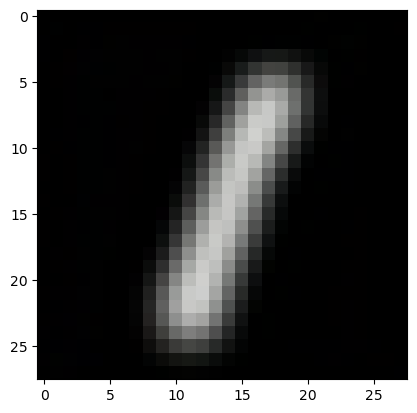

In [154]:
plt.imshow(x_t[80][0].permute([1, 2, 0]).cpu() * 0.5 + 0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


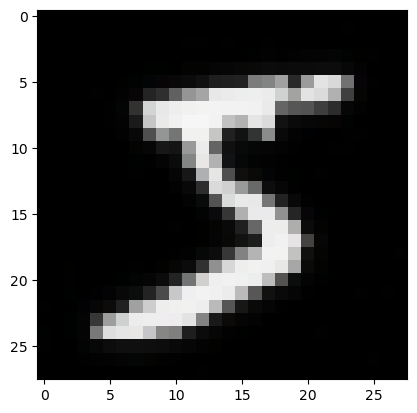

In [108]:

plt.imshow(x_t_samples[0].permute([1, 2, 0]) * 0.5 + 0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


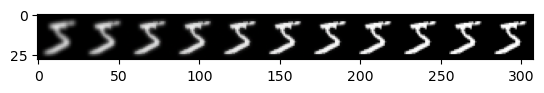

In [109]:
to_plot = x_t_samples[::10].permute([2, 3, 1, 0])
to_plot = torch.cat([to_plot[:, :, :, i] for i in range(to_plot.shape[3])], 1)
plt.imshow(to_plot * 0.5 + 0.5)

In [81]:
x_0 = sample_images[0]
x_0 = x_0.unsqueeze(0).repeat([t_range.shape[0], 1, 1, 1])
x_0.shape

torch.Size([101, 3, 32, 32])

In [113]:
bm_model.load_state_dict(torch.load('bm_debur_mnist_test.pth'))



<All keys matched successfully>